In [1]:
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV, ARDRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

In [2]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = '../data/redd/low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,3):
    print('House {}: '.format(i), labels[i], '\n')

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 



In [3]:
def read_merge_data(house):
    path = '../data/redd/low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df.filter(regex='(mains.+|microwave.+|refrigerator.+)')
df = {}
for i in range(1,3):
    df[i] = read_merge_data(i)

In [4]:
for i in range(1,3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].head(3))

House 1 data has shape:  (406748, 4)


,mains_1,mains_2,refrigerator_5,microwave_11
2011-04-18 13:22:13,222.20,118.83,6.0,5.0
2011-04-18 13:22:16,223.17,119.19,6.0,5.0
2011-04-18 13:22:20,223.60,118.92,6.0,5.0


House 2 data has shape:  (316840, 4)


,mains_1,mains_2,microwave_6,refrigerator_9
2011-04-18 05:31:40,15.71,22.61,4.0,6.0
2011-04-18 05:31:44,15.71,22.61,5.0,6.0
2011-04-18 05:31:47,15.72,22.61,4.0,6.0


In [5]:
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 



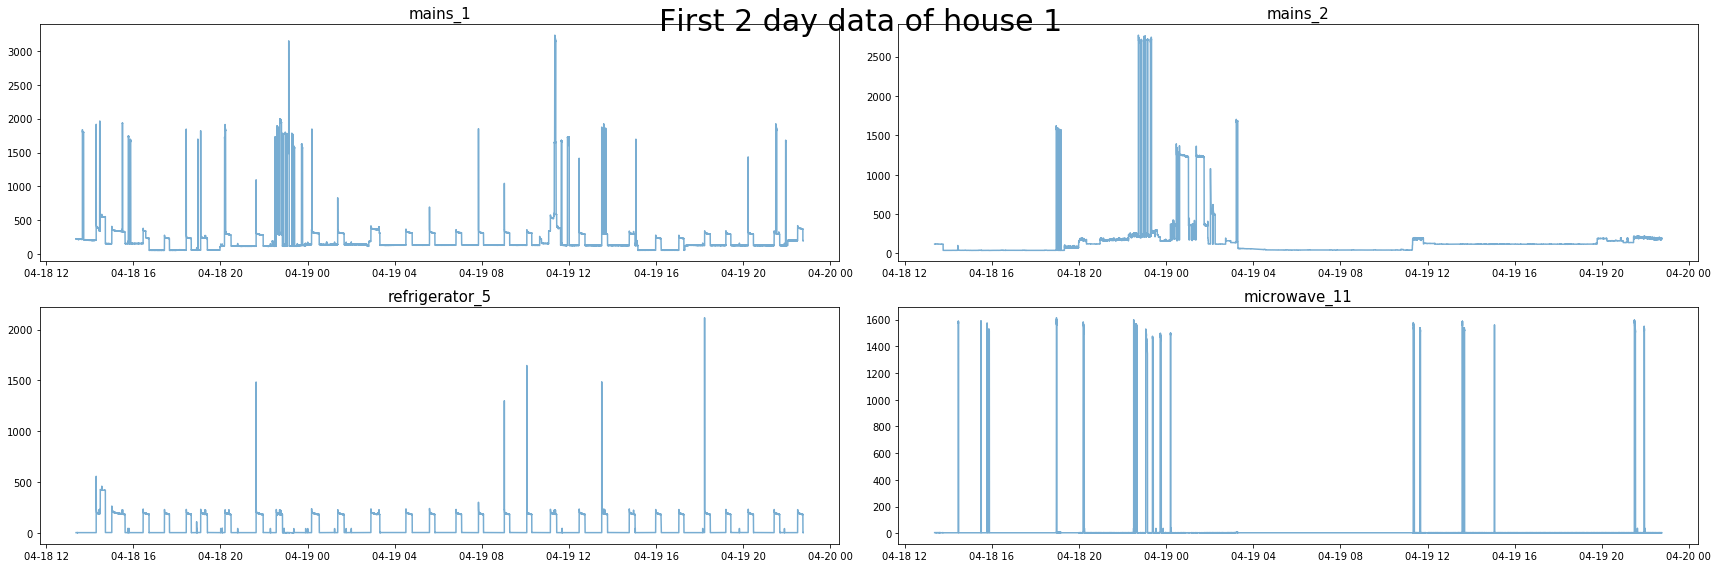

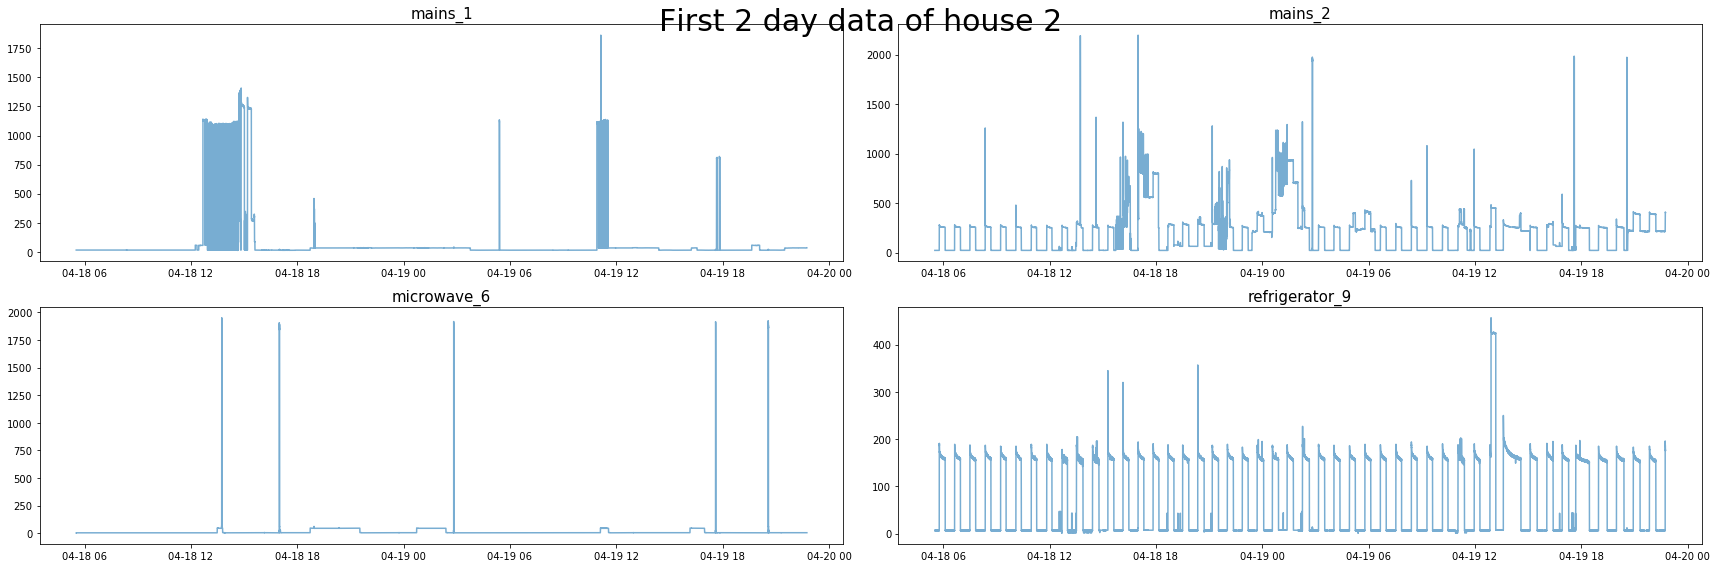

In [6]:
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.6)
        axes.flat[i].set_title(key, fontsize = '15')
    plt.suptitle(title, fontsize = '30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

for i in range(1,3):
    plot_df(df[i].ix[:dates[i][1]], 'First 2 day data of house {}'.format(i))


Text(0.5, 1.0, 'House 2')

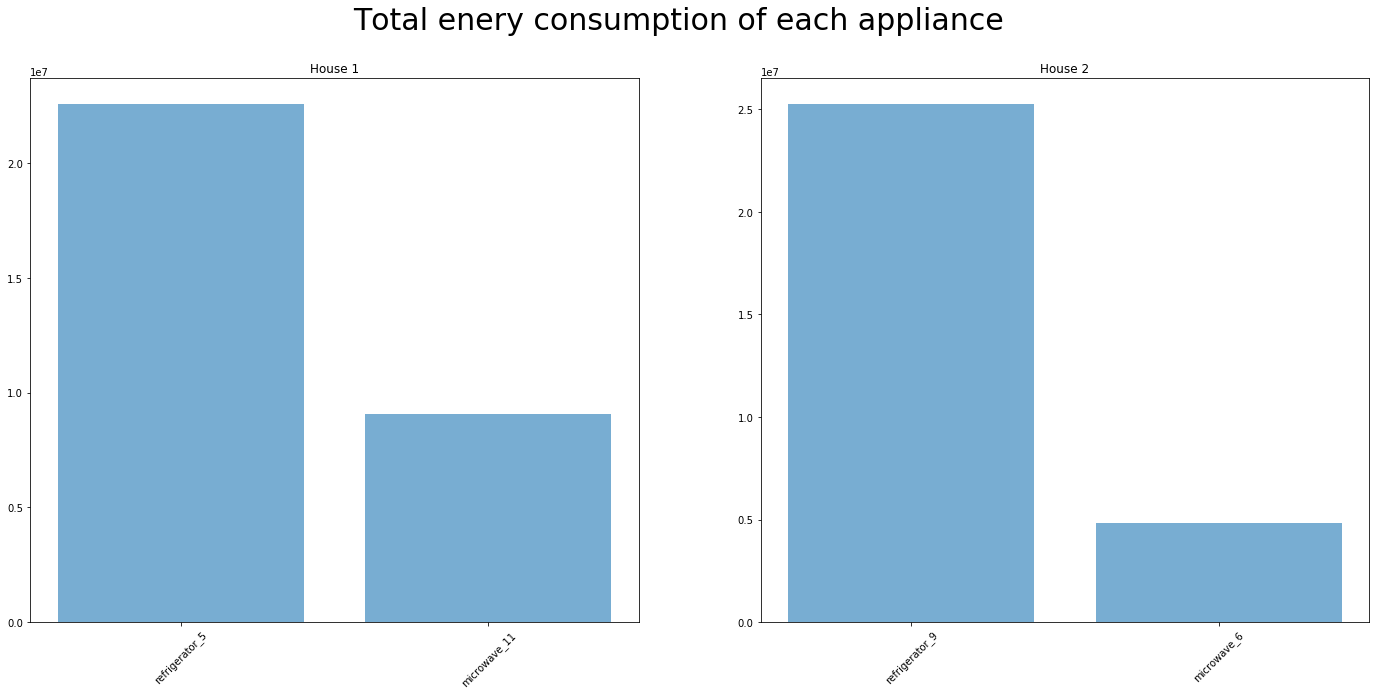

In [7]:
fig, axes = plt.subplots(1,2,figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.6) 
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')

In [8]:
def create_sliding_window(k):
    w = list()
    i = 0
    queue = list()
    for index, row in df[1].iterrows():
        if i < k:
            queue.append((row['mains_1'], row['mains_2']))
        else:
            record = list()
            record.append(index)
            record.append(row['mains_1'])
            record.append(row['mains_2'])
            for j in queue:
                record.append(j[0])
                record.append(j[1])
            record.append(row['microwave_11'])
            w.append(record)
        i += 1
    w = pd.DataFrame(w)
    w.set_index(0, inplace=True)
    w.head(10)
    c = [i for i in range(1, (k * 2) + 4)]
    return w, c

In [20]:
def train_model(k, model, normalize_data=False):
    print('Window shape: {}'.format(k))
    windows, columns = create_sliding_window(k)
    df1_train = windows.ix[:dates[1][16]]
    df1_test = windows.ix[dates[1][17]:]
    print('df_train.shape: ', df1_train.shape)
    print('df_test.shape: ', df1_test.shape)
    X_train1 = df1_train[columns[:-1]].values
    y_train1 = df1_train[columns[-1]].values
    X_test1 = df1_test[columns[:-1]].values
    y_test1 = df1_test[columns[-1]].values
    if normalize_data:
        X_train1 = normalize(X_train1)
        X_test1 = normalize(X_test1)
    print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)
    model.fit(X_train1, y_train1)
    print('Training Done')
    predictions = model.predict(X_test1)
    mae = mean_absolute_error(y_test1, predictions)
    mse = mean_squared_error(y_test1, predictions)
    rmse = np.sqrt(mean_squared_error(y_test1, predictions))
    return predictions, y_test1, df1_test, mae, mse, rmse 

In [21]:
results = list()
preds = list()
gts = list()
test_dfs = list()

In [22]:
%%time
sizes = [50, 100, 200]
models = [ARDRegression() for _ in range(len(sizes))]
for s in range(len(sizes)):
    p, gt, tdf, mae, mse, rmse = train_model(sizes[s], models[s], normalize_data=True)
    results.append([sizes[s], mae, mse, rmse])
    preds.append(p)
    gts.append(gt)
    test_dfs.append(tdf)
results = pd.DataFrame(results, columns = ['size', 'MAE', 'MSE', 'RMSE'])
results.set_index('size', inplace=True)

Window shape: 50
df_train.shape:  (319641, 103)
df_test.shape:  (87057, 103)
(319641, 102) (319641,) (87057, 102) (87057,)
Training Done
Window shape: 100
df_train.shape:  (319591, 203)
df_test.shape:  (87057, 203)
(319591, 202) (319591,) (87057, 202) (87057,)
Training Done
Window shape: 200
df_train.shape:  (319491, 403)
df_test.shape:  (87057, 403)
(319491, 402) (319491,) (87057, 402) (87057,)
Training Done
CPU times: user 1h 2min 44s, sys: 12min 25s, total: 1h 15min 9s
Wall time: 32min 7s


In [23]:
results

,MAE,MSE,RMSE
size,,,
50,55.811648,15162.880419,123.137648
100,61.549410,15095.192167,122.862493
200,63.261492,14834.319721,121.796222


In [24]:
%%time
sizes = [50, 100, 200]
models = [RidgeCV() for _ in range(len(sizes))]
for s in range(len(sizes)):
    p, gt, tdf, mae, mse, rmse = train_model(sizes[s], models[s], normalize_data=True)
    results.append([sizes[s], mae, mse, rmse])
    preds.append(p)
    gts.append(gt)
    test_dfs.append(tdf)
results = pd.DataFrame(results, columns = ['size', 'MAE', 'MSE', 'RMSE'])
results.set_index('size', inplace=True)

Window shape: 50
df_train.shape:  (319641, 103)
df_test.shape:  (87057, 103)
(319641, 102) (319641,) (87057, 102) (87057,)
Training Done
Window shape: 100
df_train.shape:  (319591, 203)
df_test.shape:  (87057, 203)
(319591, 202) (319591,) (87057, 202) (87057,)
Training Done
Window shape: 200
df_train.shape:  (319491, 403)
df_test.shape:  (87057, 403)
(319491, 402) (319491,) (87057, 402) (87057,)
Training Done
CPU times: user 5min 49s, sys: 38.7 s, total: 6min 27s
Wall time: 5min 8s


In [25]:
results

,MAE,MSE,RMSE
size,,,
NaN,55.811648,15162.880419,123.137648
NaN,61.549410,15095.192167,122.862493
NaN,63.261492,14834.319721,121.796222


In [26]:
%%time
sizes = [50, 100, 200]
models = [RandomForestRegressor() for _ in range(len(sizes))]
for s in range(len(sizes)):
    p, gt, tdf, mae, mse, rmse = train_model(sizes[s], models[s])
    results.append([s, mae, mse, rmse])
    preds.append(p)
    gts.append(gt)
    test_dfs.append(tdf)
results = pd.DataFrame(results, columns = ['size', 'MAE', 'MSE', 'RMSE'])
results.set_index('size', inplace=True)

Window shape: 50
df_train.shape:  (319641, 103)
df_test.shape:  (87057, 103)
(319641, 102) (319641,) (87057, 102) (87057,)
Training Done
Window shape: 100
df_train.shape:  (319591, 203)
df_test.shape:  (87057, 203)
(319591, 202) (319591,) (87057, 202) (87057,)
Training Done
Window shape: 200
df_train.shape:  (319491, 403)
df_test.shape:  (87057, 403)
(319491, 402) (319491,) (87057, 402) (87057,)
Training Done
CPU times: user 7min 25s, sys: 13.5 s, total: 7min 38s
Wall time: 7min 50s


In [27]:
results

,MAE,MSE,RMSE
size,,,
NaN,55.811648,15162.880419,123.137648
NaN,61.549410,15095.192167,122.862493
NaN,63.261492,14834.319721,121.796222


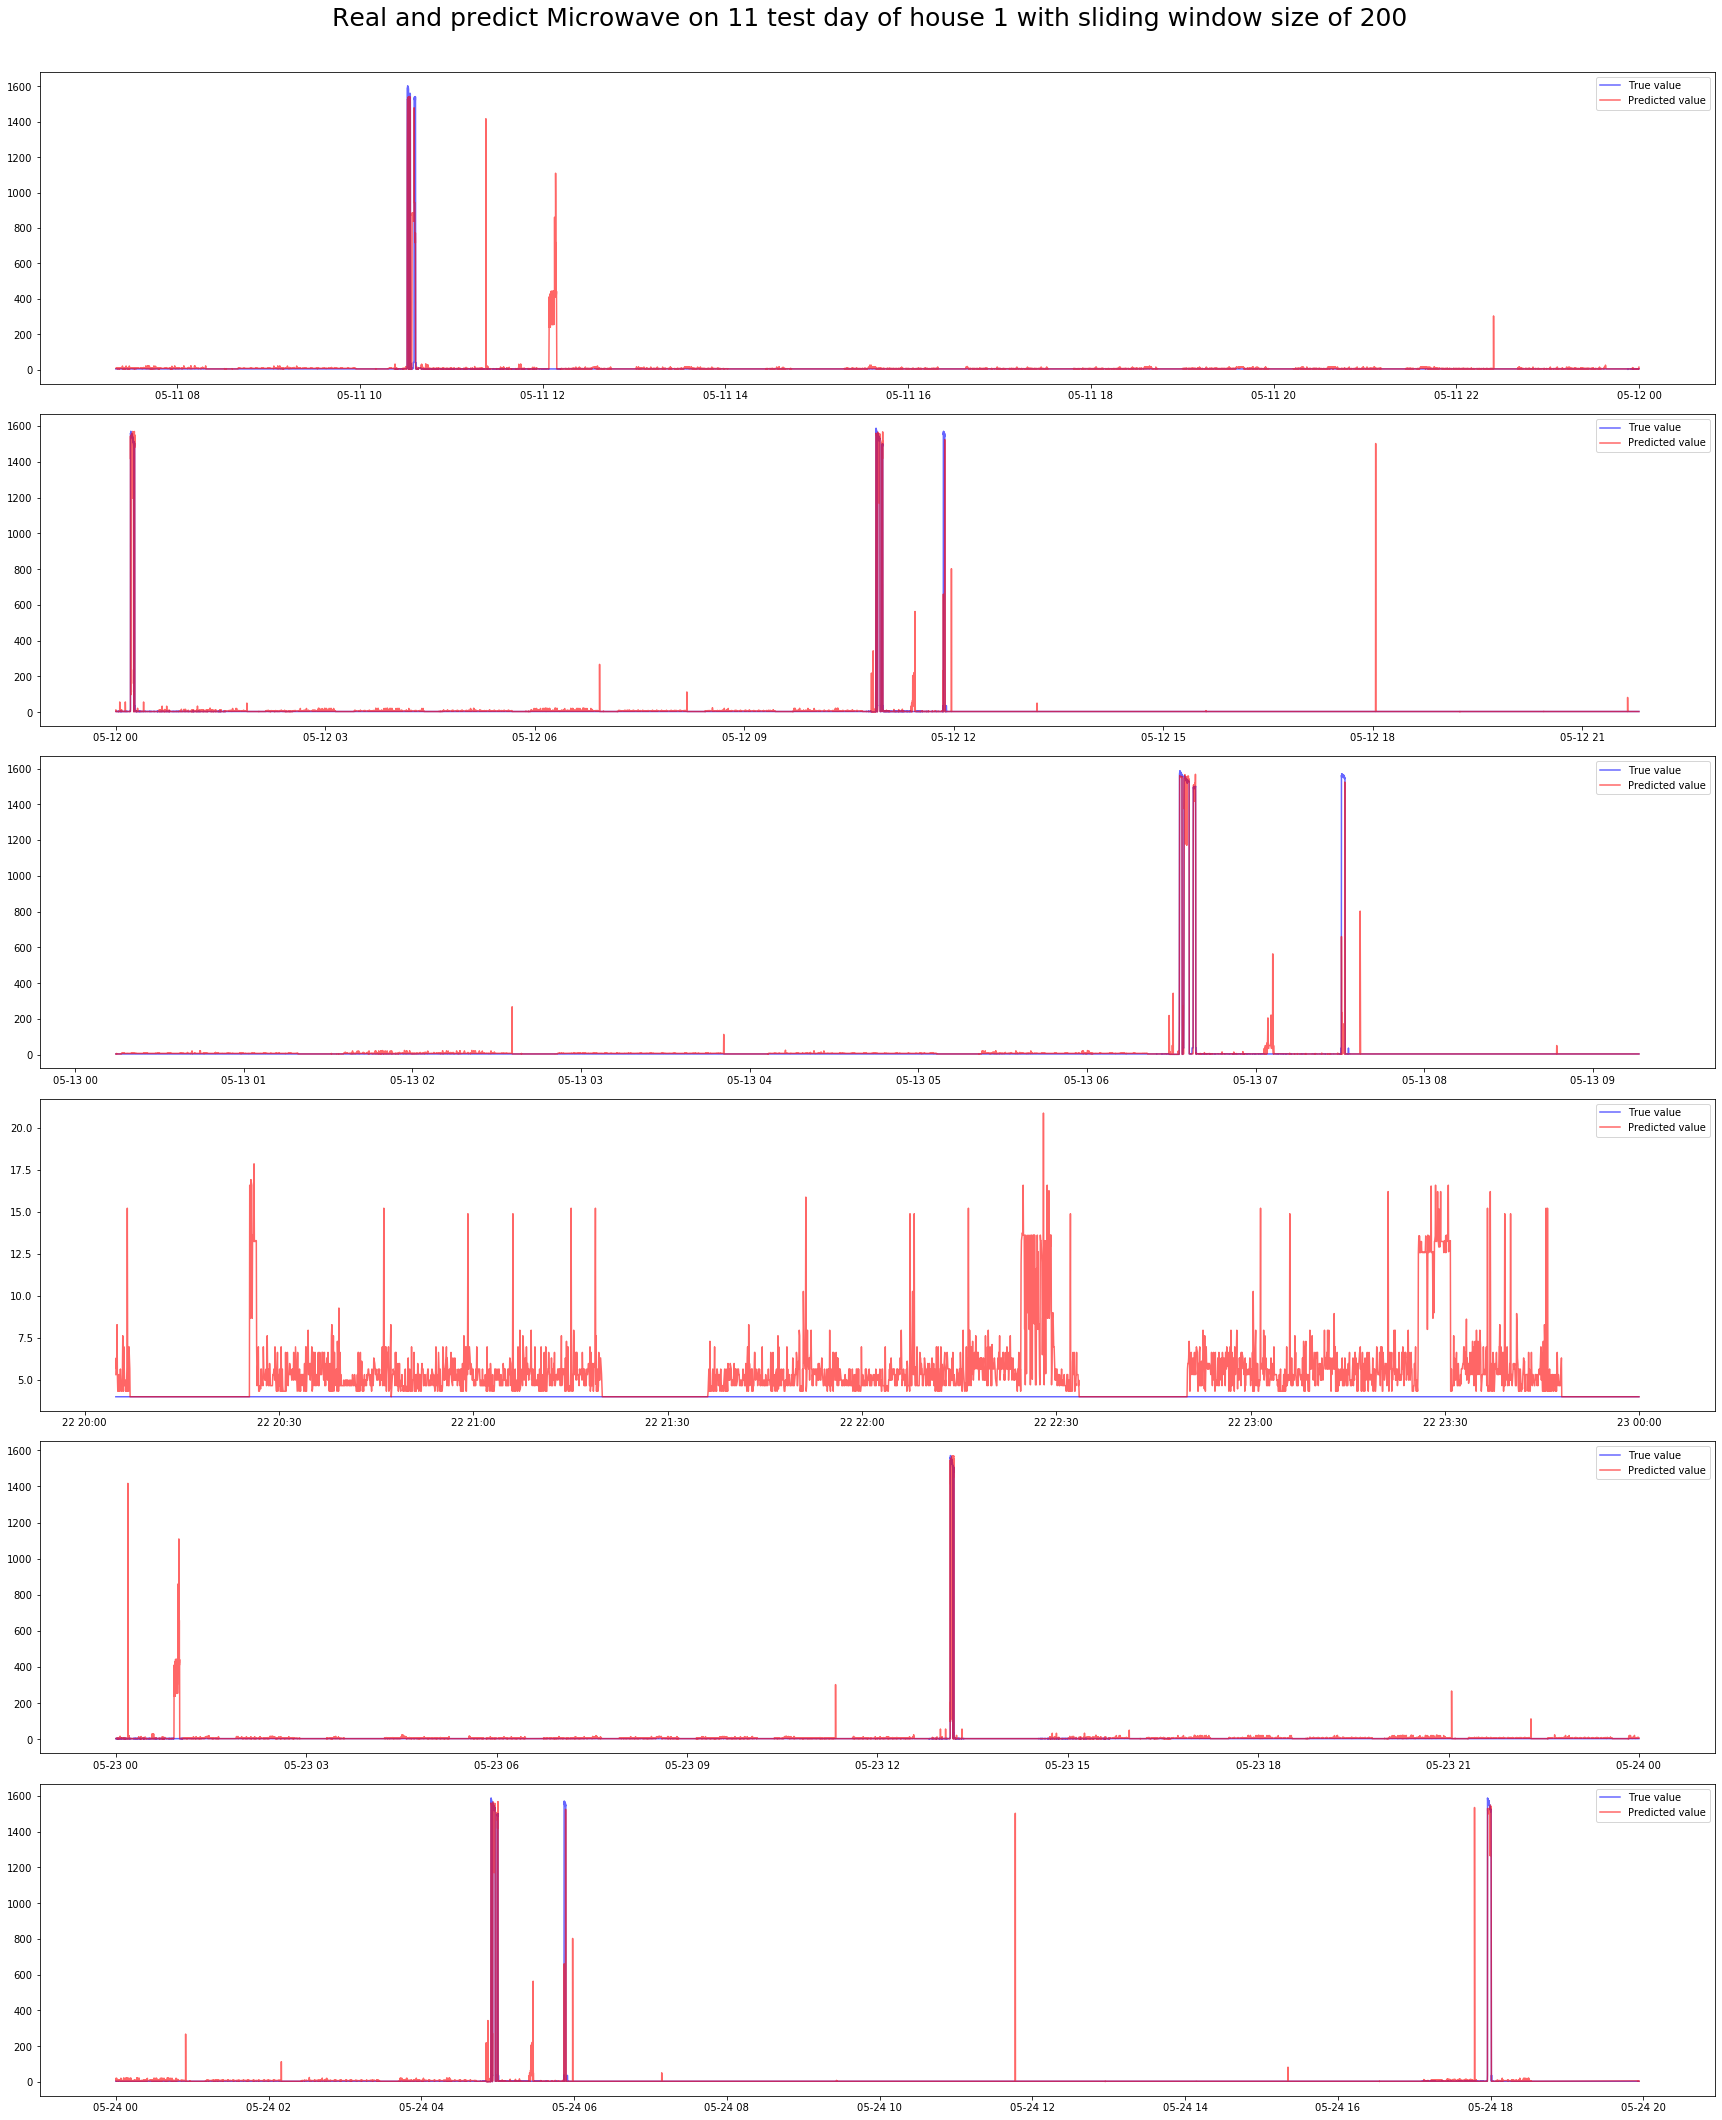

In [17]:
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.ix[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)

# for i in range(len(sizes)):
plot_each_app(test_dfs[0], dates[1][17:], preds[0], gts[0], 'Real and predict Microwave on 11 test day of house 1 with sliding window size of {}'.format(sizes[i]))

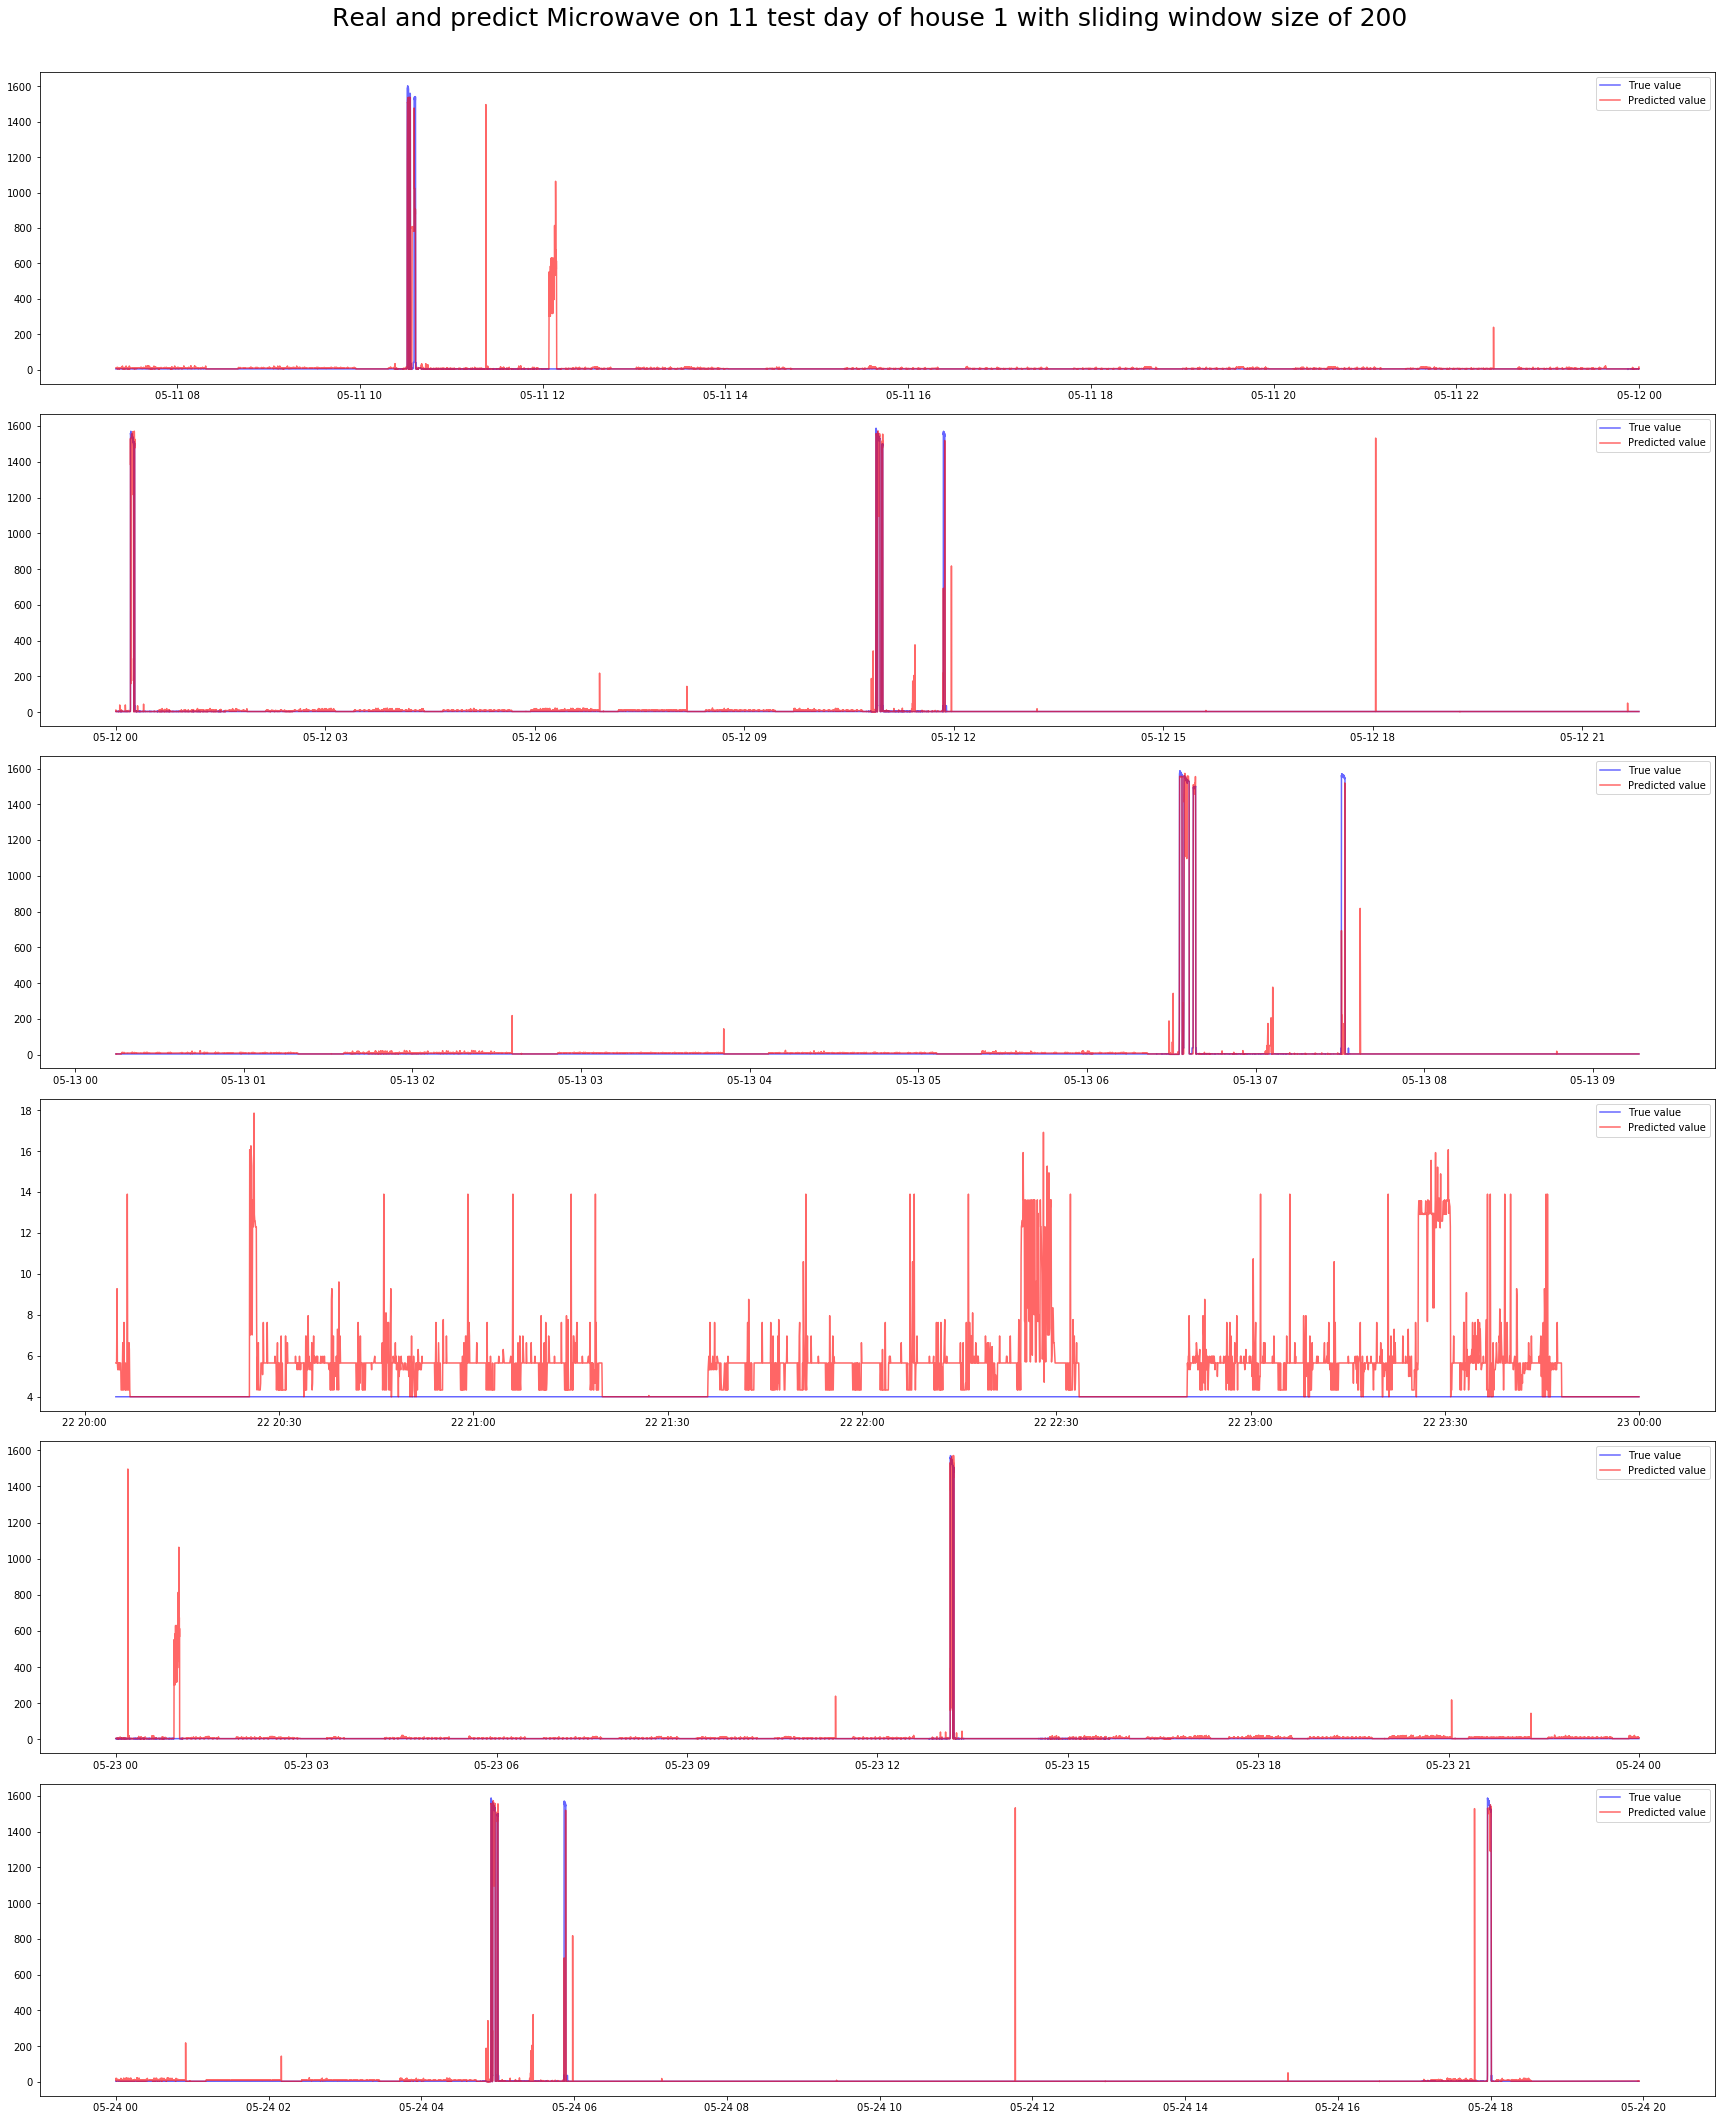

In [18]:
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.ix[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)

# for i in range(len(sizes)):
plot_each_app(test_dfs[1], dates[1][17:], preds[1], gts[1], 'Real and predict Microwave on 11 test day of house 1 with sliding window size of {}'.format(sizes[i]))

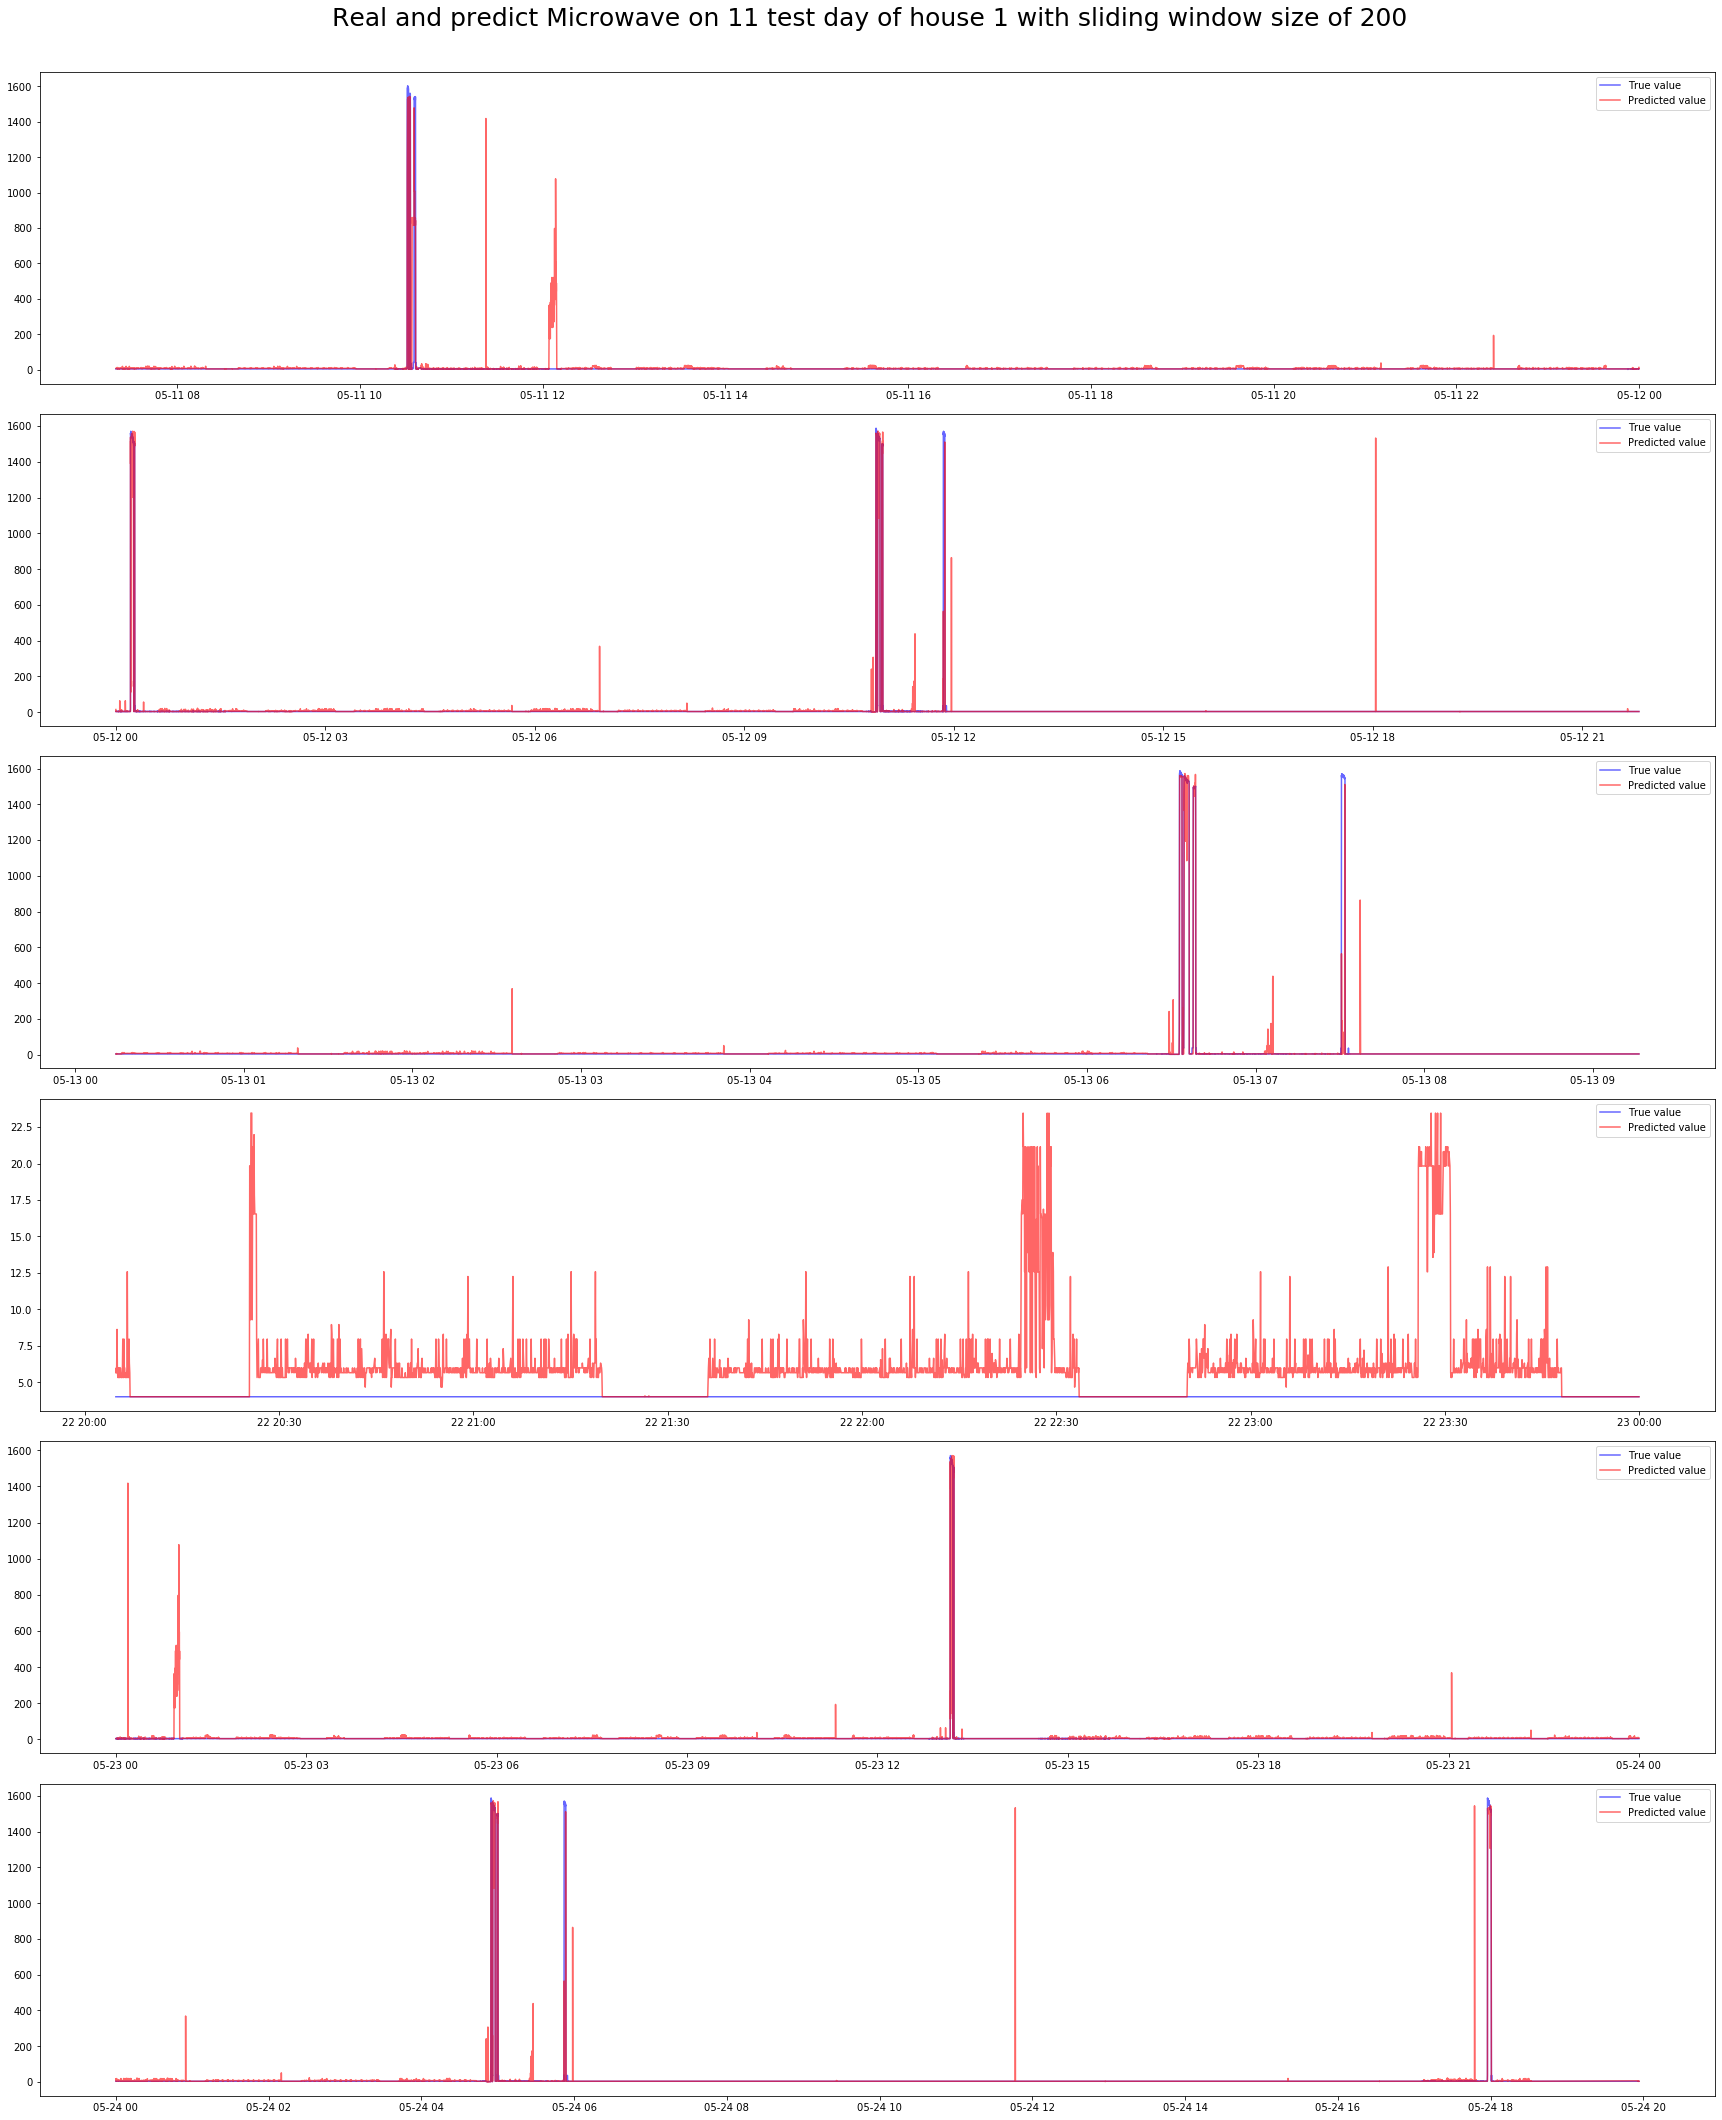

In [19]:
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.ix[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)

# for i in range(len(sizes)):
plot_each_app(test_dfs[2], dates[1][17:], preds[2], gts[2], 'Real and predict Microwave on 11 test day of house 1 with sliding window size of {}'.format(sizes[i]))